# Introduction to PyTorch

Here, we'll show code for networks of increasing complexity that perform digit recognition on the classic MNIST handwritten digit dataset.

*Note:  This notebook is intended to be runnable in Google Colab, and runs faster if you select a GPU runtime in the upper right corner.  Consider signing up for Colab Pro, which is free to students - verifying you're a student takes about 10 minutes or less, and then you'll have much more free GPU time before running out.*

*Alternately, you can run this notebook in the SCC, BU's high performance computing cluster.  Go to scc-ondemand.bu.edu, go to Interactive Apps at the top, and choose Jupyter notebook.  Use the following parameters to ensure all modules are loaded:*

* List of modules to load (space separated): miniconda academic-ml/fall-2025
* Pre-Launch Command (optional): conda activate fall-2025-pyt
* You can leave everything else at the default settings.

# First pass:  Basic shallow network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Our first instruction to PyTorch is to use a GPU if one is available.  GPUs are available on Google Colab if you pick an appropriate runtime (T4 GPU, selectable from a little downward pointing arrow in the upper right).  They are also generally available in the SCC, and they might be available locally on your laptop - try the command and see.  Using a GPU speeds up neural network training greatly, since many matrix operations can be parallelized.

In general, PyTorch is more explicit than its competitor TensorFlow about when and how the GPU gets used.

In [2]:
if torch.cuda.is_available():
  print("GPU detected")
  device = torch.device("cuda")
else:
  print("No GPU detected")
  device = torch.device("cpu")

GPU detected


Next, the data gets loaded and normalized. ToTensor() converts an image with dimensions height x width x channel with values in the range [0, 255] into a tensor with dimensions [channel x height x width] in the range [0.0, 1.0]; features in this range tend to work better than arbitrarily large integers.



The DataLoader class will handle the shuffling (if shuffle=True) of data between epochs and the batching of data (into groups of size batch_size) so that we don't need to manually apply these operations.  On a big system, it can also load examples in parallel if given a num_workers argument.

datasets.MNIST is a built-in torchvision function specifically for downloading the MNIST dataset.

In [3]:
train_loader = DataLoader(
    # Download MNIST training data to ./data and apply the transform
    datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.80MB/s]


Let's see some examples of our handwritten digits.

Label: tensor(6)
Label: tensor(7)
Label: tensor(4)


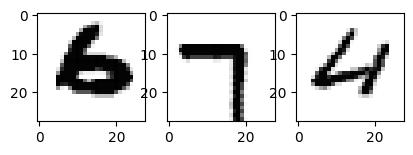

In [4]:
import matplotlib.pyplot as plt
max_images = 3
# Grab one batch to show
images, labels = next(iter(train_loader))
for i in range(max_images):
  print("Label: " + str(labels[i]))
  plt.subplot(1, max_images+1, i+1)
  # squeeze() turns 1 x 28 x 28 to 28 x 28
  plt.imshow(images[i].squeeze(), cmap='Greys')

Here's one way to define a neural network in PyTorch, which offers flexibility in how the layers are used.

* Inherit from the torch.nn.Module class and call its super constructor - this way everything else in pytorch will know how to interact with this network.
* In the constructor, define the layers of the network as attributes of the class.
* Override the forward() method so that it does the full forward computation of the network on its input.  There may be details on how the network works here that aren't obvious from its constructor - pooling, flattening, and other operations may happen here.

In [5]:
class SimpleNN(nn.Module):
    # Simple neural network with 28^2 inputs, 64 hidden units, 10 output classes
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()     # Turns (28, 28) to (784,)
        self.fc1 = nn.Linear(784, 64)   # Input layer to hidden layer; fc = "fully connected"
        self.fc2 = nn.Linear(64, 10)    # Hidden layer to output layer

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))  # Activation: sigmoid
        x = F.softmax(self.fc2(x), dim=1)  # Activation: softmax over classes
        return x

We can use the torchinfo package to examine a network's architecture after creating it.  This says the output of the first linear layer is 64x64, for example, because there are 64 batches and each has 64 hidden unit activations.

In [19]:
!pip install torchinfo

In [27]:
from torchinfo import summary
model = SimpleNN()
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [64, 10]                  --
├─Flatten: 1-1                           [64, 784]                 --
├─Linear: 1-2                            [64, 64]                  50,240
├─Linear: 1-3                            [64, 10]                  650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.26
Input size (MB): 0.20
Forward/backward pass size (MB): 0.04
Params size (MB): 0.20
Estimated Total Size (MB): 0.44

When we create a new network, we can load it onto the GPU so that all its computations happen there.

In [28]:
model = SimpleNN().to(device)

We'll use basic stochastic gradient descent to optimize for this first network.

In [29]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now it's time to train.
* `model.train()` sets the neural network to "training mode" (as opposed to "evaluation mode") enabling any behaviors that just work during training (like dropout if we had it).
* `data` and `target` are Tensors.  The `.to()` method lets us load them into the GPU's RAM.
* `zero_grad()` zeros out the gradient information from the last backpropagation pass - it would otherwise accumulate (almost never what you want).
* We are using a basic squared error loss function, which requires the targets to be one-hot encoded ([0, 0, 1, ...])instead of encoded as 0-9.
* Backprop is divided into two steps: `loss.backward()` triggers automatic differentiation and computes and stores the gradient of the loss for all parameters.  `optimizer.step()` applies the weight updates that are implied by the gradients of `loss.backward()`.  Neither does much without the other.


In [30]:
for epoch in range(30):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        target_one_hot = F.one_hot(target, num_classes=10).float()
        loss = F.mse_loss(model(data), target_one_hot)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} done.")


Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Epoch 20 done.
Epoch 21 done.
Epoch 22 done.
Epoch 23 done.
Epoch 24 done.
Epoch 25 done.
Epoch 26 done.
Epoch 27 done.
Epoch 28 done.
Epoch 29 done.


Now we can see how to evaluate on a validation or test set.
* Just as model.train() set the model to training mode, model.eval() turns off behaviors that are specific to training.
* Normally during training, forward computations also build a computation graph and save intermediate results that can be used to speed backpropagation.  Evaluation typically is done with torch.no_grad(), which disables this bookkeeping for speed.
* If we were reporting training accuracy, we wouldn't want to run passes over the whole network twice - we'd try to compute this error using the same outputs that generate the loss for backpropagation.

In [ ]:
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        # compare to target for all values, sum, and extract
        # the number from the single-element Tensor
        correct += pred.eq(target).sum().item()

# We can actually get up to 0.88 if we train the model enough
# (200 epochs), but this takes a while
print(f"Test accuracy: {correct / len(test_loader.dataset):.4f}")

Test accuracy: 0.2918


# Second pass:  Convolutions with data augmentation

In a convolutional network, the data needs to retain its shape as training occurs.  But aside from the reshape, we can use the same MNIST data.

Instead of just using "dense" (fully connected) layers with a weight per pixel, this architecture trains 3x3 convolutional filters - 32 of them in the first layer, 64 in the second - to detect features all over the image.  Since the network is deep, we also change to a rectifier activation function in the early layers.  The MaxPooling2D just reduces the size of the inputs at that layer by taking the max of each value in a 2x2 square.  Then the network is finally "flattened" so that the values are once again a single vector instead of 2 dimensional, and the final layers are a standard fully connected layer followed by a softmax layer.

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # (1, 28, 28) → (32, 26, 26)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # (64, 24, 24)
        self.pool = nn.MaxPool2d(kernel_size=2)       # → (64, 12, 12)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [7]:
model = CNNModel().to(device)

In [33]:
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 26, 26]          320
├─Conv2d: 1-2                            [64, 64, 24, 24]          18,496
├─MaxPool2d: 1-3                         [64, 64, 12, 12]          --
├─Flatten: 1-4                           [64, 9216]                --
├─Linear: 1-5                            [64, 128]                 1,179,776
├─Linear: 1-6                            [64, 10]                  1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 771.27
Input size (MB): 0.20
Forward/backward pass size (MB): 30.02
Params size (MB): 4.80
Estimated Total Size (MB): 35.02

If we're not doing anything fancy, we can use a different format for the network
where we just define the layers, and use their built-in forward functions.  This
can help prevent bugs where you change the structure but forget to update the forward function, or vice versa.

In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)

In [9]:
model = model.to(device)

In [44]:
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 26, 26]          320
├─ReLU: 1-2                              [64, 32, 26, 26]          --
├─Conv2d: 1-3                            [64, 64, 24, 24]          18,496
├─ReLU: 1-4                              [64, 64, 24, 24]          --
├─MaxPool2d: 1-5                         [64, 64, 12, 12]          --
├─Flatten: 1-6                           [64, 9216]                --
├─Linear: 1-7                            [64, 128]                 1,179,776
├─ReLU: 1-8                              [64, 128]                 --
├─Linear: 1-9                            [64, 10]                  1,290
├─Softmax: 1-10                          [64, 10]                  --
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 771.27
Input size (MB): 0.20


For data augmentation, we can change the loaders so that they randomly rotate the images for us on loading.  But we'll just do this for training - no sense in making testing more difficult.

In [10]:
rot_transform = transforms.Compose([
    transforms.RandomRotation(degrees=18),
    transforms.ToTensor()
])

train_loader = DataLoader(
    # Download MNIST training data to ./data and apply the transform
    datasets.MNIST(root='./data', train=True, download=True, transform=rot_transform),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=False
)

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

This time, we'll include running updates on the train and test accuracies.  The metrics for train accuracy are computed using the same outputs as backpropagation.

In [13]:
def get_test_accuracy(model, test_loader):
  model.eval()
  with torch.no_grad():
    test_correct = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1)
      test_correct += pred.eq(target).sum().item()
  return test_correct / len(test_loader.dataset)

for epoch in range(15):
    model.train()
    correct = 0
    total_count = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        target_one_hot = F.one_hot(target, num_classes=10).float()
        loss = F.mse_loss(output, target_one_hot)
        loss.backward()
        optimizer.step()
        total_count += data.size(0)
    print(f"Epoch {epoch} done.")
    train_accuracy = correct / total_count
    print(f"Train accuracy: {train_accuracy}")
    test_accuracy = get_test_accuracy(model, test_loader)
    print(f"Test accuracy: {test_accuracy}")



Epoch 0 done.
Train accuracy: 0.16075
Test accuracy: 0.2711
Epoch 1 done.
Train accuracy: 0.28526666666666667
Test accuracy: 0.3242
Epoch 2 done.
Train accuracy: 0.3404333333333333
Test accuracy: 0.3877
Epoch 3 done.
Train accuracy: 0.39481666666666665
Test accuracy: 0.4509
Epoch 4 done.
Train accuracy: 0.43728333333333336
Test accuracy: 0.4945
Epoch 5 done.
Train accuracy: 0.5535333333333333
Test accuracy: 0.6403
Epoch 6 done.
Train accuracy: 0.6812833333333334
Test accuracy: 0.804
Epoch 7 done.
Train accuracy: 0.8006833333333333
Test accuracy: 0.867
Epoch 8 done.
Train accuracy: 0.8394833333333334
Test accuracy: 0.8861
Epoch 9 done.
Train accuracy: 0.8549666666666667
Test accuracy: 0.8946
Epoch 10 done.
Train accuracy: 0.8635
Test accuracy: 0.9002
Epoch 11 done.
Train accuracy: 0.8692166666666666
Test accuracy: 0.9025
Epoch 12 done.
Train accuracy: 0.87235
Test accuracy: 0.9071
Epoch 13 done.
Train accuracy: 0.8768833333333333
Test accuracy: 0.9082
Epoch 14 done.
Train accuracy: 0.87

# Third pass:  Modern optimizations

We can make this network still better by incorporating a few more modern ideas.

* A dropout layer randomly zeros signals during training, forcing the network to become more robust to missing information.

* Cross-entropy is a better loss function than mean squared error for classification tasks. MSE has more vanishing gradient problems and is generally slow when combined with softmax.

* We'll use Adam as the optimizer - recall that this is a variation on gradient descent that adds momentum and tries to damp oscillations.

In [14]:
# We'll make this a class again because we're re-using the architecture later
class CNNModel2(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)    # (28,28) to (26,26)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)   # (26,26) to (24,24)
        self.pool = nn.MaxPool2d(kernel_size=2)         # (24,24) to (12,12)
        self.dropout1 = nn.Dropout(0.25)                # 25% chance of drop
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)  # No softmax for cross-entropy loss
        return x

In [15]:
model = CNNModel2().to(device)

In [50]:
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel2                                [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 26, 26]          320
├─Conv2d: 1-2                            [64, 64, 24, 24]          18,496
├─MaxPool2d: 1-3                         [64, 64, 12, 12]          --
├─Dropout: 1-4                           [64, 64, 12, 12]          --
├─Flatten: 1-5                           [64, 9216]                --
├─Linear: 1-6                            [64, 128]                 1,179,776
├─Dropout: 1-7                           [64, 128]                 --
├─Linear: 1-8                            [64, 10]                  1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 771.27
Input size (MB): 0.20
Forward/backward pass size (MB): 30.02
Params size (MB): 4.80
Estimated Total Size (MB): 35.02

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
for epoch in range(15):
    model.train()
    correct = 0
    total_count = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_count += data.size(0)
    print(f"Epoch {epoch} done.")
    train_accuracy = correct / total_count
    print(f"Train accuracy: {train_accuracy:.4f}")
    test_accuracy = get_test_accuracy(model, test_loader)
    print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 0 done.
Train accuracy: 0.9081
Test accuracy: 0.9833
Epoch 1 done.
Train accuracy: 0.9610
Test accuracy: 0.9878
Epoch 2 done.
Train accuracy: 0.9691
Test accuracy: 0.9880
Epoch 3 done.
Train accuracy: 0.9719
Test accuracy: 0.9899
Epoch 4 done.
Train accuracy: 0.9751
Test accuracy: 0.9914
Epoch 5 done.
Train accuracy: 0.9778
Test accuracy: 0.9918
Epoch 6 done.
Train accuracy: 0.9794
Test accuracy: 0.9922
Epoch 7 done.
Train accuracy: 0.9802
Test accuracy: 0.9928
Epoch 8 done.
Train accuracy: 0.9804
Test accuracy: 0.9923
Epoch 9 done.
Train accuracy: 0.9829
Test accuracy: 0.9935
Epoch 10 done.
Train accuracy: 0.9831
Test accuracy: 0.9938
Epoch 11 done.
Train accuracy: 0.9842
Test accuracy: 0.9931
Epoch 12 done.
Train accuracy: 0.9842
Test accuracy: 0.9936
Epoch 13 done.
Train accuracy: 0.9849
Test accuracy: 0.9932
Epoch 14 done.
Train accuracy: 0.9862
Test accuracy: 0.9933


Seems pretty good!  The model in action:

Predicted class: 7 — Actual class: 7


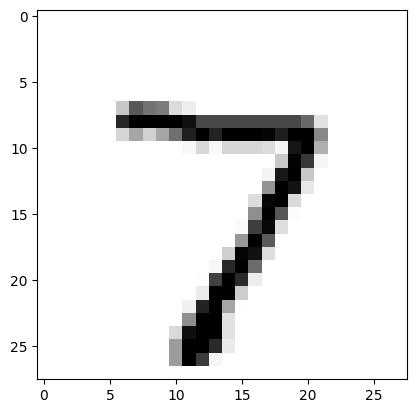

In [18]:
batch, label = next(iter(test_loader))

plt.imshow(batch[0][0], cmap='Greys')

# "Unsqueeze" adds a dimension of size 1 at index 0, putting back the batch dim
image = batch[0].unsqueeze(0).to(device)  # shape: [1, C, H, W]
label = label[0].to(device)

with torch.no_grad():
    output = model(image)
    pred = output.argmax(dim=1)

print(f"Predicted class: {pred.item()} — Actual class: {label.item()}")

# Transfer learning

VGG16 is an already trained classifier that can identify hundreds of objects in real-world images.  You can leverage this learning for new machine learning problems by importing the trained VGG16 network, then training some fully connected layers on top of it while keeping the VGG16 part of the network fixed.  VGG16 should have many helpful feature detectors trained already that should speed up the learning and avoid overfitting.

Note that this works less well for black and white drawings - it's typically used for detecting things in photos, which are what it was trained on.  But 3D objects are harder than black and white drawings - we're less likely to see 90%+ accuracy right out the gate without some transfer learning.

In [19]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

t = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
      mean=[0.485, 0.456, 0.406],         # ImageNet stats
      std=[0.229, 0.224, 0.225]
    ),
])

train_ds = datasets.STL10(
    root="data",
    split="train",
    download=True,
    transform=t
)
test_ds  = datasets.STL10(
    root="data",
    split="test",
    download=True,
    transform=t
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader  = DataLoader(test_ds,  batch_size=64)

100%|██████████| 2.64G/2.64G [07:40<00:00, 5.74MB/s]


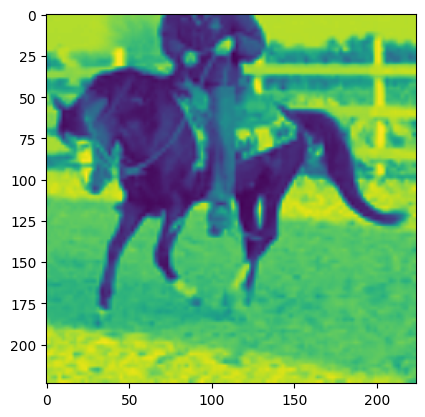

In [20]:
import matplotlib.pyplot as plt

data_iter = iter(valid_loader)
image, label = next(data_iter)

plt.imshow(image[0][0])

In [21]:
vgg = models.vgg16(pretrained=True)

# Freeze pretrained layers
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace classifier head - note the forward
# method already calls vgg.classifier(x) so we don't
# need to rewrite it
vgg.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(25088, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),  # 10 classes in STL10
    nn.Softmax(dim=1)
)

vgg = vgg.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.7MB/s]


In [22]:
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.0001)

In [23]:
criterion = nn.CrossEntropyLoss()
for epoch in range(7):
    vgg.train()
    total_loss = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch} — Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

    val_accuracy = get_test_accuracy(vgg, valid_loader)
    print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch 0 — Loss: 143.8179, Accuracy: 0.7184
Validation Accuracy: 0.9241
Epoch 1 — Loss: 124.3203, Accuracy: 0.9236
Validation Accuracy: 0.9393
Epoch 2 — Loss: 121.3916, Accuracy: 0.9532
Validation Accuracy: 0.9435
Epoch 3 — Loss: 119.5813, Accuracy: 0.9690
Validation Accuracy: 0.9454
Epoch 4 — Loss: 118.7387, Accuracy: 0.9756
Validation Accuracy: 0.9455
Epoch 5 — Loss: 117.8779, Accuracy: 0.9834
Validation Accuracy: 0.9467
Epoch 6 — Loss: 117.4339, Accuracy: 0.9880
Validation Accuracy: 0.9480


# Early Stopping and Plotting

In training, there's often a point at which the model starts to overfit - validation performance gets worse as training performance continues to improve or plateaus.  We want the model that is at the base of the "U" curve for validation loss.  We can address this in two ways:

* Track the number of consecutive epochs that loss hasn't gone down, and if it's larger than a "patience" parameter of 3, stop.  We can also save the smallest loss model so that we don't overshoot.  This is called "early stopping."
* Plot the validation loss over time to visually confirm that we hit the "U" and this isn't just wobbly improvement.  (We can plot the training loss over time too - if it's not improving, there may be something deeply wrong.)

Early stopping is typically tied to loss instead of accuracy, because there can be times where the loss is improving but it doesn't improve enough to change the accuracy yet.  Plotting accuracy gives a more intuitive view of how the model is doing, though.

In [29]:
# Reload the "modern optimizations" model
model = CNNModel2().to(device)

In [25]:
# Copied from earlier - need to redefine the loaders after VGG16
rot_transform = transforms.Compose([
    transforms.RandomRotation(degrees=18),
    transforms.ToTensor()
])

train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=rot_transform),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size=1000, shuffle=False
)

In [30]:
def get_accuracy_and_loss(model, test_loader, criterion):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    test_correct = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1)
      test_correct += pred.eq(target).sum().item()
      loss = criterion(output, target)
      test_loss += loss.item()
  return test_correct / len(test_loader.dataset), test_loss / len(test_loader.dataset)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 3
epochs_without_improve = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(100):  # Can be arbitrarily large if we're early stopping
    model.train()
    train_loss = 0
    correct = 0
    total_count = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total_count += data.size(0)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} done.")
    train_accuracy = correct / total_count
    train_loss = train_loss / total_count
    print(f"Train accuracy: {train_accuracy}")
    train_accuracies.append(train_accuracy)
    print(f"Train loss: {train_loss}")
    train_losses.append(train_loss)
    val_accuracy, val_loss = get_accuracy_and_loss(model, test_loader, criterion)
    print(f"Val accuracy: {val_accuracy}")
    val_accuracies.append(val_accuracy)
    print(f"Val loss: {val_loss}")
    val_losses.append(val_loss)
    # Check for improvement
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), 'best_model.pth')
      epochs_without_improve = 0
    else:
      epochs_without_improve += 1
      if epochs_without_improve >= patience:
        break



Epoch 0 done.
Train accuracy: 0.9020666666666667
Train loss: 0.004939757915834586
Val accuracy: 0.9837
Val loss: 5.0286856573075056e-05
Epoch 1 done.
Train accuracy: 0.95625
Train loss: 0.0022317607421583185
Val accuracy: 0.9864
Val loss: 4.087676140479743e-05
Epoch 2 done.
Train accuracy: 0.9665
Train loss: 0.0017429478605200225
Val accuracy: 0.9874
Val loss: 3.660456016659736e-05
Epoch 3 done.
Train accuracy: 0.9699333333333333
Train loss: 0.0015701252055820077
Val accuracy: 0.9898
Val loss: 2.9858190915547312e-05
Epoch 4 done.
Train accuracy: 0.9731666666666666
Train loss: 0.0014097005923899512
Val accuracy: 0.9907
Val loss: 2.921417250763625e-05
Epoch 5 done.
Train accuracy: 0.9751
Train loss: 0.0013039428251096978
Val accuracy: 0.9901
Val loss: 2.8061017813161016e-05
Epoch 6 done.
Train accuracy: 0.9764666666666667
Train loss: 0.0012001554045826196
Val accuracy: 0.9909
Val loss: 2.7779911016114055e-05
Epoch 7 done.
Train accuracy: 0.9777
Train loss: 0.001123128892038949
Val accura

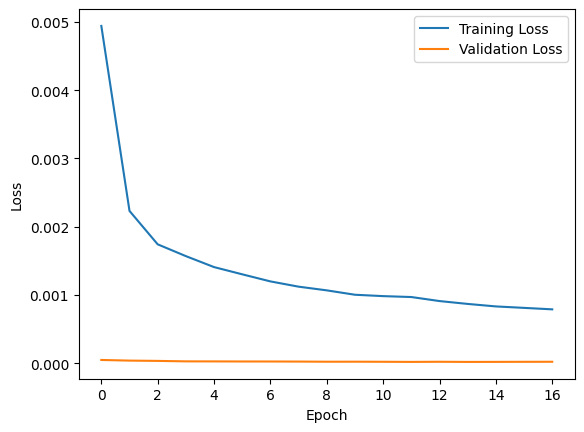

In [31]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

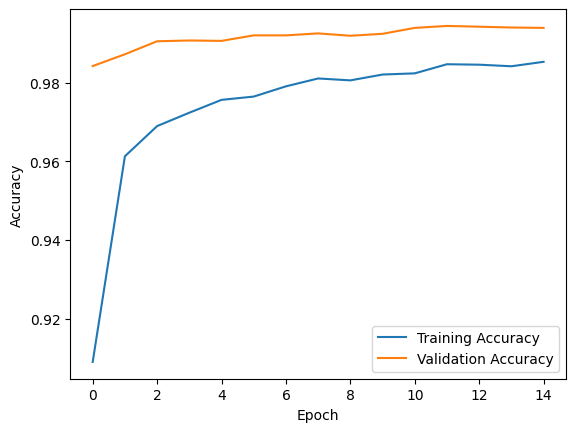

In [28]:
import matplotlib.pyplot as plt
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()